In [1]:
from schrutepy import schrutepy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import streamlit as st
from matplotlib.pyplot import figure
import nltk
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from PIL import Image
import numpy as np
import collections
import pandas as pd
pd.set_option('display.max_rows',10000)
pd.set_option('display.max_columns',100)
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode,iplot
import plotly.graph_objects as go
import cufflinks as cf
from sklearn.metrics import classification_report, accuracy_score
from ml_things import plot_dict, plot_confusion_matrix, fix_text

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/traffic/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning:

urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!



In [ ]:
SELECT  FROM `datascience-abovezero.ml_sandbox.chegg_influencers_comments` LIMIT 1000

In [2]:
st.title('Sentimental Analysis')

2022-03-18 18:07:14.457 
  command:

    streamlit run /home/traffic/.local/lib/python3.8/site-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

# Data Prep

In [3]:
#loading the data
df = pd.read_csv('analisis_comments_tiktok.csv')
dfl = pd.read_csv('/home/traffic/data/analisis_comments_tiktok_labeled.csv',sep=';',decimal=',')

#### Inspecting Data

In [4]:
df.head()

,date_post,date_extraction,influencer,post_type,post_url,platform,comment,comment_likecount,replies,BU;;;;;;;;;
0,"2021-9-12,2021-12-01,espdaniella,VIDEO,https:/...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-9-12,2021-12-01,espdaniella,VIDEO,https://www.tiktok.com/@espdaniella/video/7007...,TikTok,it’s not good chegg apparently rats out on stu...,14,NaN,CS;;;;;;;;;
2,"2021-9-11,2021-12-01,themccartys,VIDEO,https:/...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-9-11,2021-12-01,themccartys,VIDEO,https://www.tiktok.com/@themccartys/video/7006...,TikTok,I hope Audri looks different at that age,71,NaN,CS;;;;;;;;;
4,2021-9-11,2021-12-01,themccartys,VIDEO,https://www.tiktok.com/@themccartys/video/7006...,TikTok,I absolutely love it!,26,NaN,CS;;;;;;;;;


In [5]:
df.describe()

,date_post,date_extraction,influencer,post_type,post_url,platform,comment,comment_likecount,replies,BU;;;;;;;;;
count,1096,1008,997,998,993,984,979,975,20,970
unique,144,19,34,11,51,9,896,38,19,7
top,2021-11-12,2021-12-01,sydneyserena,VIDEO,https://www.youtube.com/watch?v=V467rq8OVsc,TikTok,Hi,0,"CS"";;;;;;;;",CS;;;;;;;;;
freq,217,720,212,970,188,722,13,621,2,930


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date_post          1096 non-null   object
 1   date_extraction    1008 non-null   object
 2   influencer         997 non-null    object
 3   post_type          998 non-null    object
 4   post_url           993 non-null    object
 5   platform           984 non-null    object
 6   comment            979 non-null    object
 7   comment_likecount  975 non-null    object
 8   replies            20 non-null     object
 9   BU;;;;;;;;;        970 non-null    object
dtypes: object(10)
memory usage: 85.8+ KB


#### Handling Data

In [7]:
# adding true labels to data
df.loc[:,'labels_true'] = dfl.lalbel.values
df.loc[:,'labels_true'] = df.apply(lambda x: 0 if int(x.labels_true)==0 else 1,axis=1)
# filtering out empty comments
df = df.loc[~df.comment.isna()]

VADER’s SentimentIntensityAnalyzer() takes in a string and returns a dictionary of scores in each of four categories:
negative
neutral
positive
compound (computed by normalizing the scores above
Let us analyze some random statements through our sentimental analyzer
a = 'This was a good movie.'

In [8]:
sid = SentimentIntensityAnalyzer()

df['scores'] = df['comment'].apply(lambda comment: sid.polarity_scores(comment))
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['comp_score'] = df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
df.loc[:,['comment','comp_score']]

,comment,comp_score
1,it’s not good chegg apparently rats out on stu...,neg
3,I hope Audri looks different at that age,pos
4,I absolutely love it!,pos
5,so this is what Audri will look like as a Fres...,pos
6,Oh my I hope not 😂,pos
7,Math is hard 😳😳😳,neg
8,This was me. I cannot MATH,pos
9,I can history all day long but I cannot math o...,pos
10,This is so neat! @Chegg for the win!,pos
11,That is a 7th grade problem😑 Won't work on my ...,pos


              precision    recall  f1-score   support

           0       0.25      0.60      0.35        35
           1       0.98      0.93      0.96       944

    accuracy                           0.92       979
   macro avg       0.62      0.77      0.66       979
weighted avg       0.96      0.92      0.94       979

Normalized confusion matrix


/home/traffic/.local/lib/python3.8/site-packages/ml_things/plot_functions.py:722: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



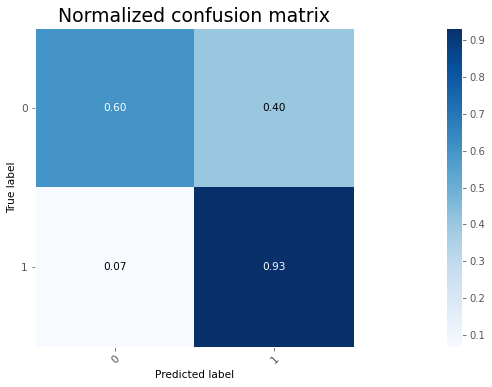

In [38]:
df.loc[:,'labels'] = df.comp_score.apply(lambda x: 1 if x=='pos' else 0)
evaluation_report = classification_report(df.labels_true, df.labels, labels=[0,1])
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=df.labels_true, y_pred=df.labels, 
                      classes=[0,1], normalize=True, 
                      magnify=0.1,
                      );

### Wronlgy labeles as negative 

In [42]:
df.loc[(df.labels==0)&(df.labels_true==1),['comment']]

,comment
7,Math is hard 😳😳😳
18,I thought this was a fake add-
19,I can never tell if your joking or not HELP-
21,🥰💝🇺🇸 no 🇺🇸🇬🇧🇨🇦😄😱🥰
29,Are you serious
35,So I’m the only one that cries on the first da...
41,I&#39;ve heard this often goes with anciety/ d...
43,@Tom Saywer I can be gone for months and then ...
46,Bakeing soda and water with Lemons along with ...
82,The heavy or frequent use of antibiotics could...


### Wrongly labeled as positive | This is where the model performs poorly

In [41]:
df.loc[(df.labels==1)&(df.labels_true==0),['comment']]

,comment
23,chegg is terrible. they log your ip and send i...
33,soooo how much bread did you get with this collab
55,For somebody who is so educated is so ignorant...
151,Tienes que mejorar tus platios. Mi mama te gan...
223,What the actual heck was the blur in the begin...
464,yes but doesnt work on other country math
518,chegg snitches on you !! don't use it 😉
540,Fixed the issue w/ 2018. Never checked if 2017...
613,I’ve been following for a year! I’m making you...
789,Gothmarh is better than Chang it let's you tak...


# EDA

In [32]:
init_notebook_mode(connected=True)
#labels
lab = df["comp_score"].value_counts().keys().tolist()
#values
val = df["comp_score"].value_counts().values.tolist()
trace = go.Pie(labels=lab, 
                values=val, 
                marker=dict(colors=['red']), 
                # Seting values to 
                hoverinfo="value"
              )
data = [trace]
layout = go.Layout(title="Sentiment Distribution")
fig = go.Figure(data = data,layout = layout)
iplot(fig)

### Sentiment Distribution per Influencer

In [39]:
for i in df.influencer.unique().tolist():
    dfi = df.loc[df.influencer==i,:].copy()
    lab = dfi["comp_score"].value_counts().keys().tolist()
    #values
    val = dfi["comp_score"].value_counts().values.tolist()
    trace = go.Pie(labels=lab, 
                    values=val, 
                    marker=dict(colors=['red']), 
                    # Seting values to 
                    hoverinfo="value"
                  )
    data = [trace]
    layout = go.Layout(title=f"{i}'s Sentiment Distribution")
    fig = go.Figure(data = data,layout = layout)
    iplot(fig)

### Influencer Rank by Sentiment

In [46]:
df_i = df.groupby(['influencer']).agg({'compound':'mean'}).reset_index()
df_i = df_i.sort_values('compound',ascending=False)
df_i

,influencer,compound
9,iamalilstitious,0.528580
18,ninjanerdscience,0.493969
1,as usual,0.401900
16,modern.day.classic,0.330317
26,sydneyserena,0.291964
7,espdaniella,0.229247
25,sarahrav,0.220103
15,medstudebt,0.200400
2,build joy,0.198240
10,itssozer,0.184557


### Focus: Negative Comments

In [49]:
df_n = df.loc[df.compound<0,:]

In [20]:
# defining data
trace = go.Histogram(x=df['platform'],nbinsx=40,histnorm='percent')
data = [trace]
# defining layout
layout = go.Layout(title="platform Distribution")
# defining figure and plotting
fig = go.Figure(data = data,layout = layout)
iplot(fig)

In [21]:
import streamlit as st
import plotly.figure_factory as ff


# Plot!
st.plotly_chart(fig, use_container_width=True)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [22]:
# defining data
trace = go.Histogram(x=df['post_type'],nbinsx=40,histnorm='percent')
data = [trace]
# defining layout
layout = go.Layout(title="post_type Distribution")
# defining figure and plotting
fig = go.Figure(data = data,layout = layout)
iplot(fig)

In [23]:
# defining data
trace = go.Histogram(x=df['compound'],nbinsx=40,histnorm='percent')
data = [trace]
# defining layout
layout = go.Layout(title="compound Distribution")
# defining figure and plotting
fig = go.Figure(data = data,layout = layout)
iplot(fig)

In [24]:
st.plotly_chart(fig, use_container_width=True)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

# GPT2 Modelling

In [4]:
df2 = pd.read_csv('/home/traffic/data/gpt2_classifications.csv')
df2.loc[:,'labels_true'] = dfl.lalbel.values
df2.loc[:,'labels_true'] = df2.apply(lambda x: 0 if int(x.labels_true)==0 else 1,axis=1)
df2 = df2.loc[~df2.comments.isna()]
df2.head()

,Unnamed: 0,comments,labels,labels_true
1,1,it’s not good chegg apparently rats out on stu...,0,0
3,3,I hope Audri looks different at that age,0,1
4,4,I absolutely love it!,1,1
5,5,so this is what Audri will look like as a Fres...,1,1
6,6,Oh my I hope not 😂,0,1


              precision    recall  f1-score   support

           0       0.04      0.77      0.08        35
           1       0.97      0.32      0.48       944

    accuracy                           0.34       979
   macro avg       0.51      0.55      0.28       979
weighted avg       0.94      0.34      0.47       979

Normalized confusion matrix


/home/traffic/.local/lib/python3.8/site-packages/ml_things/plot_functions.py:722: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



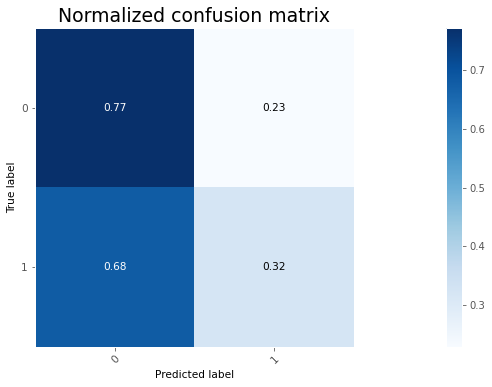

In [9]:
evaluation_report = classification_report(df2.labels_true, df2.labels, labels=[0,1])
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=df2.labels_true, y_pred=df2.labels, 
                      classes=[0,1], normalize=True, 
                      magnify=0.1,
                      );

## Wrongly labeled as negative | This is where the model performs poorly

In [45]:
df2.loc[(df2.labels==0)&(df2.labels_true==1),['comments']]

,comments
3,I hope Audri looks different at that age
6,Oh my I hope not 😂
7,Math is hard 😳😳😳
8,This was me. I cannot MATH
11,That is a 7th grade problem😑 Won't work on my ...
12,Why you holding a charger up to your mouth
14,same oh my gosh is this an actual sponsor thin...
15,wait how am i so early
17,Early
18,I thought this was a fake add-


## Wrongly labeled as positive

In [46]:
df2.loc[(df2.labels==1)&(df2.labels_true==0),['comments']]

,comments
151,Tienes que mejorar tus platios. Mi mama te gan...
311,Be careful guys! Some universities see Chegg a...
538,Chegg literally had a class action lawsuit for...
540,Fixed the issue w/ 2018. Never checked if 2017...
613,I’ve been following for a year! I’m making you...
757,most of it isnt very helpful for those outside...
789,Gothmarh is better than Chang it let's you tak...
1016,yeah chegg finds locations of students and ema...
